In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Modelo 1: Clasificación binar

## Objetivo del modelo

El objetivo de este primer modelo implementado es clasificar cada simulacro del dataset TEP como:
- 0 → No ocurrió ningún fallo
- 1 → Ocurrió un fallo
Es decir que se busca detectar si ya ha ocurrido un fallo basándose en las mediciones y variables de control de cada simulacro.

### Preparación de los datos

Lo primero es carga de datasets:
- TEP_features_train.csv para entrenamiento
- TEP_features_test.csv para evaluación

In [6]:
train_path = "DatasetProcesado/TEP_features_train.csv"
test_path  = "DatasetProcesado/TEP_features_test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

Seguimos definiendo la variable objetivo. Para esto se utiliza la columna fault_present, que ya estaba codificada como 0/1. Una copia fallo_bin es creada para mayor claridad en el código.

In [7]:
# Ahora usamos 'fault_present' que ya viene con 0/1
df_train['fallo_bin'] = df_train['fault_present']
df_test['fallo_bin']  = df_test['fault_present']

Durante la selección de features se eliminan del conjunto de entrenamiento las columnas directamente relacionadas con la variable objetivo (fault_present y fallo_bin) para evitar “filtrado trivial”. Todas las demás variables (xmeas_*, xmv_* y derivados) se usaron como features.

In [8]:
X_train = df_train.drop(['fault_present', 'fallo_bin'], axis=1)
y_train = df_train['fallo_bin']

X_test  = df_test.drop(['fault_present', 'fallo_bin'], axis=1)
y_test  = df_test['fallo_bin']

Por último en esta primera parte se implementa la normalización. Para ello se aplica StandardScaler para estandarizar los features, lo que mejora la estabilidad del modelo y es buena práctica aunque Random Forest no lo requiere estrictamente.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Selección del modelo
Dando paso al modelo en sí, toca seleccionar el modelo. El elegido es Random Forest Classifier por varias razones:
- La capacidad de manejar datasets con muchas features y relaciones no lineales.
- La robustez a ruido y la falta de requirimiento de mucha normalización de datos.
- La facilidad de interpretar a nivel global (feature importance) y muy efectivo para clasificación binaria.

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluación del modelo
Por último, para evaluar los resultados del modelo, se han implementado 3 métricas: Confusión matrix, classification report y ROC-AUC Score

In [12]:
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[ 19200      0]
 [     0 192000]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19200
           1       1.00      1.00      1.00    192000

    accuracy                           1.00    211200
   macro avg       1.00      1.00      1.00    211200
weighted avg       1.00      1.00      1.00    211200


ROC-AUC Score:
1.0


Como muestra la matriz de confusión, hay un desequilibrio en la proporción del dataset: la clase 1 (fallo) tiene 192,000 ejemplos, mientras que la clase 0 (sin fallo) tiene 19,200. Esto es un desequilibrio de 10:1. Cabe aclarar que este desequilibrio no es un error en la reducción, sino una decisión intencionada con el fin de respetar la proporción del dataset original.

### Conclusión

Por lo que muestran las metricas, la exactitud obtenida es perfecta (accuracy = 1.0), lo que indica que el modelo distingue perfectamente simulacros con fallo de los que no tienen fallo. A pesar de lo mencionado del desequilibrio entre clases, el modelo predice ambas clases correctamente. Como se puede ver en las métricas, los resultados muestran un acierto del 100% en la clasificación.

Como conclusión sobre el desempeño, se puede afirmar que el modelo está cumpliendo el objetivo inicial: identificar si ha ocurrido un fallo en cada simulacro.

# Modelo 2: Predicción de fallos

## Objetivo del modelo

El objetivo de este modelo es predecir si ocurrirá un fallo en el sistema TEP en los próximos HORIZON pasos. Esto permite anticipar posibles problemas y actuar antes de que se produzcan, funcionando como un sistema de alerta temprana.

### Preparación de los datos

Lo primero es cargar los datasets, archivos predefinidos de entrenamiento y prueba para respetar la separación temporal.

In [4]:
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

Seguimos definiendo la variable objetivo. Para esto se utiliza la columna fallo_futuro, que indica si habrá fallo en los próximos HORIZON pasos. .shift(-HORIZON) desplaza la columna hacia adelante, .fillna(0) evita NaNs.

In [5]:
HORIZON = 10
df_train['fallo_futuro'] = df_train['fault_present'].shift(-HORIZON).fillna(0).astype(int)
df_test['fallo_futuro']  = df_test['fault_present'].shift(-HORIZON).fillna(0).astype(int)

Durante la selección de features se eliminan columnas que contienen información directa del fallo actual para que el modelo no “haga trampa”.

In [6]:
features_to_drop = ['fault_present', 'fallo_futuro', 'time_since_fault', 'fault_stage']
X_train = df_train.drop(columns=[col for col in features_to_drop if col in df_train.columns])
y_train = df_train['fallo_futuro']
X_test  = df_test.drop(columns=[col for col in features_to_drop if col in df_test.columns])
y_test  = df_test['fallo_futuro']

Por último en esta primera parte se implementa el escalado. Aunque Random Forest no requiere escalado estrictamente, pero se aplica por consistencia y preparación de futuros modelos.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Selección del modelo
El modelo elegido es Random Forest por su robustez ante datasets con muchas variables y su capacidad de manejar relaciones no lineales. Hay 2 variables que vale la pena mencionar/explicar.
- n_estimators=200 para estabilidad en la predicción.
- class_weight='balanced' corrige el desbalance natural de fallos vs no-fallos.

In [8]:
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluación del modelo
Para evaluar el modelo se usan tres métricas (confusion matrix, classification report y ROC-AUC) por diferentes motivos.
- Confusion Matrix: muestra TP, TN, FP y FN, permitiendo ver la exactitud de predicción de fallos y no-fallos.
- Classification Report: muestra precisión, recall y f1-score; el recall es especialmente importante para fallos (evitar no detectar fallos).
- ROC-AUC: evalúa la capacidad del modelo de separar correctamente las clases, robusto frente al desbalance.

In [16]:
y_pred  = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[ 18405    795]
 [    39 191961]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19200
           1       1.00      1.00      1.00    192000

    accuracy                           1.00    211200
   macro avg       1.00      0.98      0.99    211200
weighted avg       1.00      1.00      1.00    211200


ROC-AUC Score:
0.9995726786295572


## Conclusiones 

Como desempeño general, se puede confirmar que la exactitud global es muy alta (~1.0), lo que indica que el modelo clasifica correctamente la gran mayoría de los registros. Sin embargo, la exactitud por sí sola puede ser engañosa debido al desbalance de clases (1:10, fallos vs no-fallos).

En cuanto a la matriz de confusión se puede interpretar por los resultados, que se detectan claramente los fallos y no fallos de la siguiente manera:
- Clase 0 (no fallo): 795 falsos positivos (predijo fallo cuando no hubo).
- Clase 1 (fallo): solo 39 falsos negativos (fallos no detectados), lo que indica que el modelo casi siempre anticipa los fallos correctamente.

La classification report, por su parte diferencia los siguientes indicadores clave para cada clase: 
- Recall de fallos (1): ~1.00 → el modelo detecta casi todos los fallos futuros, lo cual es crítico para un sistema de alerta temprana.
- Recall de no-fallos (0): 0.96 → el modelo comete algunos falsos positivos, lo que puede generar alertas innecesarias pero es menos crítico que no detectar un fallo real.
- F1-score: combina precisión y recall; sigue siendo muy alto para ambas clases, confirmando buen equilibrio.

Lo último mostrado, ROC-AUC Score, tiene un valor que enseña un valor muy cercano a 1. Esto se interpresa como que el modelo tiene una excelente capacidad de separar correctamente las clases de fallo y no-fallo, incluso con desbalance.

Con todo ello, se puede concluir que el modelo es confiable para anticipar fallos y puede ser utilizado para sistemas de mantenimiento predictivo o alertas tempranas. La presencia de falsos positivos es manejable; es preferible alertar de más a perder un fallo real. La decisión de usar class_weight='balanced' y Random Forest ha sido acertada para manejar el desbalance y capturar la complejidad del sistema.

# Modelo 3: Clasificador de fallos

Importamos las librerias y cargamos los datos necesarios para el modelo.

In [2]:
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Comprobamos las primeras filas de los datasets.

In [14]:
# Revisar tamaño y primeras filas
print("Tamaño df_train:", df_train.shape)
print("Primeras filas df_train:")
print(df_train.head())

print("\nTamaño df_test:", df_test.shape)
print("Primeras filas df_test:")
print(df_test.head())

Tamaño df_train: (110000, 370)
Primeras filas df_train:
   faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0           10.0       1  0.25125   3671.5   4498.3   9.3137   
1          0.0           10.0       2  0.25068   3661.1   4533.6   9.2646   
2          0.0           10.0       3  0.24835   3656.7   4496.2   9.3947   
3          0.0           10.0       4  0.24777   3649.6   4524.2   9.4125   
4          0.0           10.0       5  0.26755   3587.1   4476.1   9.3137   

   xmeas_5  xmeas_6  xmeas_7  ...  xmv_2_scaled  xmv_3_scaled  xmv_4_scaled  \
0   26.652   42.276   2705.1  ...      0.294590     -0.020349     -0.463884   
1   26.894   42.133   2705.6  ...     -0.601851     -0.002255      0.620707   
2   27.098   42.706   2704.4  ...      0.345452      0.072662     -0.792333   
3   26.842   42.766   2704.5  ...     -0.364495      0.090756     -1.165678   
4   27.090   42.104   2703.6  ...      1.574614      0.453591     -1.414575   

   xmv

Eliminamos las columnas que no se usan como features.

faultNumber indica el tipo de fallo, fault_present indica si hay fallo y simulationRun y sample no aportan informacion al modelo de predicción.

In [4]:
# Features y target
X_train = df_train.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_train = df_train["faultNumber"]

X_test = df_test.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_test = df_test["faultNumber"]

Revisamos el número de features y la distribución de clases para ver si hay balance.

In [16]:
print("Número de features:", X_train.shape[1])
print("Clases en y_train:", y_train.value_counts())
print("Clases en y_test:", y_test.value_counts())

Número de features: 366
Clases en y_train: faultNumber
0.0     10000
11.0     5000
19.0     5000
18.0     5000
17.0     5000
16.0     5000
15.0     5000
14.0     5000
13.0     5000
12.0     5000
10.0     5000
1.0      5000
9.0      5000
8.0      5000
7.0      5000
6.0      5000
5.0      5000
4.0      5000
3.0      5000
2.0      5000
20.0     5000
Name: count, dtype: int64
Clases en y_test: faultNumber
0     19200
11     9600
19     9600
18     9600
17     9600
16     9600
15     9600
14     9600
13     9600
12     9600
10     9600
1      9600
9      9600
8      9600
7      9600
6      9600
5      9600
4      9600
3      9600
2      9600
20     9600
Name: count, dtype: int64


Entrenamos el modelo Random Forest multiclase.

n_estimator para un modelo estable, random_state para asegurar reproducibilidad y n_jobs para usar la CPU.

In [5]:
# Entrenar modelo multiclase
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

Evaluamos el modelo.

In [6]:
# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19200
           1       0.98      0.92      0.95      9600
           2       0.97      0.87      0.92      9600
           3       0.86      1.00      0.92      9600
           4       0.85      0.93      0.89      9600
           5       0.97      0.85      0.91      9600
           6       0.97      0.86      0.91      9600
           7       0.91      0.88      0.90      9600
           8       0.83      0.99      0.90      9600
           9       0.89      0.84      0.87      9600
          10       1.00      0.83      0.91      9600
          11       1.00      0.83      0.91      9600
          12       0.98      0.83      0.90      9600
          13       0.99      0.81      0.89      9600
          14       1.00      0.83      0.91      9600
          15       1.00      0.83      0.91      9600
          16       1.00      0.79      0.88      9600
          17       1.00    

Creamos una matriz de confusión para ver que fllos se predicen correctamente y cuales no.

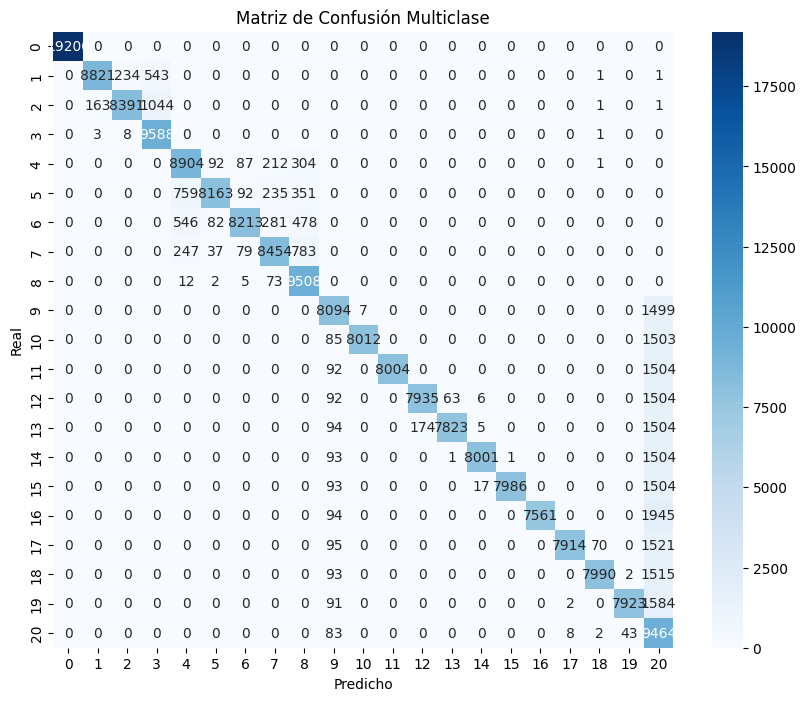

In [7]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión Multiclase")
plt.show()

Creamos una función para predecir el tipo de fallo de una simulación, 0 indica que esa simulación no tiene fallo.

In [12]:
def predecir_fallo(nueva_simulacion):
    """
    nueva_simulacion: DataFrame con columnas xmeas_1…xmeas_41 y xmv_1…xmv_11
    """
    pred = model.predict(nueva_simulacion)
    return pred[0]

# Ejemplo de uso:
nueva_sim = df_test.drop(columns=["faultNumber","fault_present","simulationRun","sample"]).iloc[[0]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))

nueva_sim = df_test.drop(columns=["faultNumber","fault_present","simulationRun","sample"]).iloc[[15000]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))


Tipo de fallo predicho: 0.0
Tipo de fallo predicho: 18.0


### Observaciones de las métricas

Clase 0 (sin fallo):

precision=1.00, recall=1.00 → perfectas
Esto es lógico si las simulaciones sin fallo son muy distintas de los fallos.
Es fácil que el modelo detecte correctamente las simulaciones normales.

Clases 1-19 (fallos típicos):

Precision y recall entre 0.81 y 1.00 → bastante bueno.
Algunas clases tienen recall más bajo (ej. clases 2,5,6,16) → se confunden con otras clases.
Esto es normal: algunos tipos de fallo pueden generar señales similares en los sensores (xmeas/xmv) y por eso el modelo no los distingue perfectamente.

Clase 20:

precision=0.36, recall=0.99 → esto indica un desequilibrio en las predicciones:
Prácticamente todas las muestras de clase 20 se detectan (recall=0.99)
Pero muchas otras muestras se clasifican erróneamente como 20 (precision=0.36)
Esto suele pasar con clases raras o muy similares a otras, o cuando hay un patrón que confunde al modelo.

Accuracy global ~88%:

Para un dataset con 21 clases (0-20), 88% es bastante aceptable.
El macro avg y weighted avg también confirman un buen comportamiento general.